In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms as T
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
import pandas as pd
import os
import numpy as np
from PIL import Image
from glob import glob

from datasets import FlowVideoDataset, FrameVideoDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch
import torch.nn as nn
from rgb_resnet import rgb_resnet50
from flow_resnet import flow_resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class TwoStreamNetwork(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(TwoStreamNetwork, self).__init__()

        # Initialize the RGB stream (spatial stream)
        self.rgb_stream = self._build_resnet(pretrained)

        # Initialize the optical flow stream (temporal stream)
        self.flow_stream = self._build_flow_resnet(pretrained)

        # Fully connected layers after concatenation of the outputs from both streams
        self.fc1 = nn.Linear(512 * 2, 1024)  # Concatenate features from both streams
        self.fc2 = nn.Linear(1024, num_classes)

         # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.8)  # Dropout with 50% probability

        self.batchnorm_fc1 = nn.BatchNorm1d(1024)  # BatchNorm for the first fully connected layer


        

    def _build_resnet(self, pretrained):
        """Build the ResNet model for RGB frames."""
        resnet = models.resnet18(pretrained=pretrained)
        # Modify the first convolution layer to take 3 input channels (standard for RGB)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        return nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and pooling layers

    def _build_flow_resnet(self, pretrained):
        """Build the ResNet model for optical flow with 18 input channels."""
        resnet = models.resnet18(pretrained=pretrained)
        # Modify the first convolution layer to take 18 input channels (for optical flow)
        resnet.conv1 = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        return nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and pooling layers

    def forward(self, rgb_frames, optical_flow):
        # Forward pass for spatial stream (RGB frames)
        batch_size, channels, num_frames, height, width = rgb_frames.size()

        # Process each RGB frame independently for the spatial stream
        spatial_features = []
        for i in range(num_frames):
            frame = rgb_frames[:, :, i, :, :]  # Extract each frame independently
            frame_features = self.rgb_stream(frame)  # Process the individual frame
            frame_features = F.adaptive_avg_pool2d(frame_features, (1, 1))  # Pool to fix output size
            spatial_features.append(frame_features.view(frame_features.size(0), -1))  # Flatten

        # Stack features from all frames and average across time (optional)
        spatial_features = torch.stack(spatial_features, dim=1)  # [batch_size, num_frames, features]
        spatial_features = spatial_features.mean(dim=1)  # Average over frames (optional)

        # Forward pass for temporal stream (Optical Flow)
        batch_size, channels, height, width = optical_flow.size()
        temporal_features = self.flow_stream(optical_flow)  # Process the entire stack of flow frames
        temporal_features = F.adaptive_avg_pool2d(temporal_features, (1, 1))  # Pool to fix output size
        temporal_features = temporal_features.view(temporal_features.size(0), -1)  # Flatten

        # Concatenate features from both streams
        combined_features = torch.cat((spatial_features, temporal_features), dim=1)

        # Apply dropout before the fully connected layers
        x = self.dropout(F.relu(self.fc1(combined_features)))
        x = self.batchnorm_fc1(x)  # Apply BatchNorm
        x = self.fc2(x)

        return x




# Combined dataset class for both frames and optical flow
class TwoStreamVideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='/work3/ppar/data/ucf101_noleakage', split='train', transform=None, stack_frames=True, resize=(64, 64)):
        self.frame_dataset = FrameVideoDataset(root_dir=root_dir, split=split, transform=transform, stack_frames=stack_frames)
        self.flow_dataset = FlowVideoDataset(root_dir=root_dir, split=split, resize=resize)
        
    def __len__(self):
        return len(self.frame_dataset)
    
    def __getitem__(self, idx):
        # Get data from both datasets
        rgb_frames, label = self.frame_dataset[idx]
        optical_flow, _ = self.flow_dataset[idx]  # No need for label here, it's already fetched

        return rgb_frames, optical_flow, label
    
# Training and Evaluation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for rgb_frames, optical_flow, labels in train_loader:
        rgb_frames = rgb_frames.to(device)
        optical_flow = optical_flow.to(device)
        labels = labels.to(device)
        print(rgb_frames.shape, optical_flow.shape, labels.shape)

        optimizer.zero_grad()

        outputs = model(rgb_frames, optical_flow)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for rgb_frames, optical_flow, labels in val_loader:
            rgb_frames = rgb_frames.to(device)
            optical_flow = optical_flow.to(device)
            labels = labels.to(device)

            outputs = model(rgb_frames, optical_flow)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


Frame dataset length: 500, Flow dataset length: 500
TwoStream dataset length: 500, TwoStream validation dataset length: 120


/zhome/28/8/203659/UNI/venv_1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/28/8/203659/UNI/venv_1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.14it/s]


Epoch 1/15
  Training Loss: 2.3232, Accuracy: 13.20%
  Validation Loss: 2.1900, Accuracy: 27.50%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.09it/s]


Epoch 2/15
  Training Loss: 2.1628, Accuracy: 19.40%
  Validation Loss: 2.1014, Accuracy: 25.83%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18it/s]


Epoch 3/15
  Training Loss: 2.0583, Accuracy: 29.60%
  Validation Loss: 2.0542, Accuracy: 30.00%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch 4/15
  Training Loss: 1.9620, Accuracy: 32.80%
  Validation Loss: 2.1100, Accuracy: 25.83%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch 5/15
  Training Loss: 1.8923, Accuracy: 40.60%
  Validation Loss: 2.2484, Accuracy: 28.33%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch 6/15
  Training Loss: 1.7813, Accuracy: 45.20%
  Validation Loss: 2.0426, Accuracy: 30.83%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s]


Epoch 7/15
  Training Loss: 1.7392, Accuracy: 49.00%
  Validation Loss: 2.0184, Accuracy: 36.67%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 8/15
  Training Loss: 1.6143, Accuracy: 57.40%
  Validation Loss: 2.2657, Accuracy: 35.83%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch 9/15
  Training Loss: 1.5040, Accuracy: 62.40%
  Validation Loss: 2.8573, Accuracy: 25.00%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 10/15
  Training Loss: 1.4511, Accuracy: 65.20%
  Validation Loss: 1.8399, Accuracy: 31.67%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch 11/15
  Training Loss: 1.3970, Accuracy: 67.00%
  Validation Loss: 1.9990, Accuracy: 40.00%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 12/15
  Training Loss: 1.3254, Accuracy: 74.20%
  Validation Loss: 1.8751, Accuracy: 38.33%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 13/15
  Training Loss: 1.2590, Accuracy: 73.20%
  Validation Loss: 1.6830, Accuracy: 41.67%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 14/15
  Training Loss: 1.1675, Accuracy: 78.20%
  Validation Loss: 1.7493, Accuracy: 40.00%


Validating Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch 15/15
  Training Loss: 1.1214, Accuracy: 79.00%
  Validation Loss: 1.7274, Accuracy: 40.00%


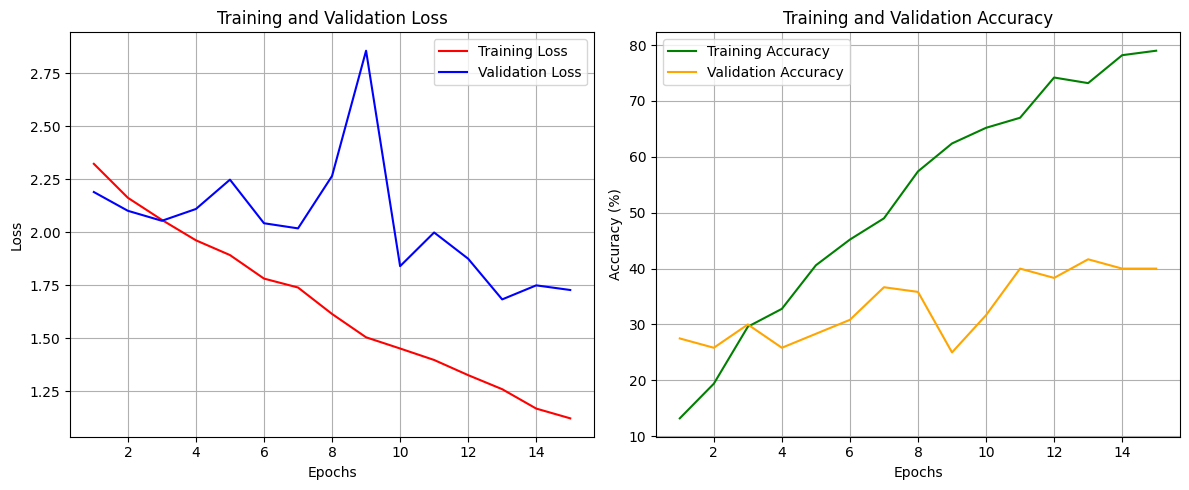

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm  # For showing the progress bar

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10  # Number of classes in UCF101

w = h = 224
size = (w, h)
# Initialize the dataset
root_dir = '/dtu/datasets1/02516/ucf101_noleakage'
transform = T.Compose([T.Resize(size), T.ToTensor()])

framevideo_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames=True)
flowvideo_dataset = FlowVideoDataset(root_dir=root_dir, split='train', resize=size)
print(f"Frame dataset length: {len(framevideo_dataset)}, Flow dataset length: {len(flowvideo_dataset)}")

twostream_dataset = TwoStreamVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames=True, resize=size)
twostream_val_dataset = TwoStreamVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames=True, resize=size)

print(f"TwoStream dataset length: {len(twostream_dataset)}, TwoStream validation dataset length: {len(twostream_val_dataset)}")

train_loader = DataLoader(twostream_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(twostream_val_dataset, batch_size=16, shuffle=False)

# Model, loss function, optimizer
model = TwoStreamNetwork(num_classes=num_classes,pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Track loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Using tqdm for a progress bar
    for rgb_frames, optical_flow, labels in tqdm(train_loader, desc="Training Epoch"):
        rgb_frames, optical_flow, labels = rgb_frames.to(device), optical_flow.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(rgb_frames, optical_flow)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for rgb_frames, optical_flow, labels in tqdm(val_loader, desc="Validating Epoch"):
            rgb_frames, optical_flow, labels = rgb_frames.to(device), optical_flow.to(device), labels.to(device)

            # Forward pass
            outputs = model(rgb_frames, optical_flow)
            loss = criterion(outputs, labels)

            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Train and validate for a few epochs and plot the results
num_epochs = 15  # Change to 100 as needed

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Store loss and accuracy for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'two_stream_ucf101.pth')

# Plotting the training and validation loss and accuracy
def plot_training_metrics(losses, accuracies, val_losses, val_accuracies):
    epochs = range(1, len(losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss', color='red')
    plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


In [6]:
# evaluate the model
framevideo_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames=True)
flowvideo_dataset = FlowVideoDataset(root_dir=root_dir, split='test', resize=(64, 64))

twostream_dataset = TwoStreamVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames=True, resize=(64, 64))

test_loader = DataLoader(twostream_dataset, batch_size=8, shuffle=False)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")



Test Loss: 3.3281, Accuracy: 40.83%


In [5]:
import torch
import matplotlib.pyplot as plt
import os

# Define class names
classes = ["class_0", "class_1", "class_2", "class_3", ..., "class_n"]  # Replace with actual class names

# Function to visualize predictions for a batch
def visualize_predictions(test_loader, model, device, batch_index=0, results_dir='results'):
    print(f'Visualizing predictions for test video batch {batch_index}')
    
    # Get the batch from the test_loader
    test_iter = iter(test_loader)
    
    # Skip to the desired batch
    for _ in range(batch_index):
        frames, optical_flow, labels = next(test_iter)
    
    # Ensure frames, optical_flow, and labels are on the correct device
    frames, optical_flow, labels = frames.to(device), optical_flow.to(device), labels.to(device)
    
    # Get predictions for the batch
    with torch.no_grad():
        outputs = model(frames, optical_flow)  # Pass both RGB frames and optical flow
        _, predicted = torch.max(outputs.data, 1)
    
    # Convert frames, predicted labels, and true labels to CPU for visualization
    frames = frames.cpu()
    predicted_classes = [classes[p.item()] for p in predicted]  # Get predicted class names
    true_classes = [classes[l.item()] for l in labels]  # Get true class names

    # Plot all frames with their predicted and true labels
    plt.figure(figsize=(15, 6))
    for i in range(min(len(frames), 10)):  # Plot up to 10 frames
        frame = frames[i].permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        plt.subplot(2, 5, i + 1)
        plt.imshow(frame)
        plt.title(f"Pred: {predicted_classes[i]}\nTrue: {true_classes[i]}")
        plt.axis('off')
    
    plt.suptitle(f'Predictions for Test Video (Batch {batch_index})')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the plot
    os.makedirs(results_dir, exist_ok=True)
    plt.savefig(os.path.join(results_dir, f'test_video_predictions_batch_{batch_index}.png'))
    plt.show()

# Example usage
# Ensure that you have the test_loader and model loaded, and adjust batch_index as needed.
visualize_predictions(test_loader, model, device, batch_index=120, results_dir='results')


Visualizing predictions for test video batch 120


StopIteration: 